### Import Libraries and Setup Path

In [1]:
import os
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from distinctipy import distinctipy
from skimage.feature import canny
from skimage.morphology import binary_dilation
# Set image directory
image_dir = './images'

In [2]:
# Get and group all image paths
image_groups = {}
for filename in os.listdir(image_dir):
    if filename.endswith(('.png')):
        base_name = filename.rsplit('_', 1)[0]
        if base_name not in image_groups:
            image_groups[base_name] = {}
        
        if 'rgb' in filename:
            image_groups[base_name]['rgb'] = os.path.join(image_dir, filename)
        elif 'depth' in filename:
            image_groups[base_name]['depth'] = os.path.join(image_dir, filename)
        elif 'gt' in filename:
            image_groups[base_name]['gt'] = os.path.join(image_dir, filename)

### Model Prediction and Visualization

In [3]:
def visualize_masks(rgb_input, masks, colors):
    # Check if input is path or PIL Image, and open if it's a path
    rgb = Image.open(rgb_input)
    rgb_np = np.array(rgb)
    img = rgb_np.copy()
    alpha = 0.33
    # Convert all masks to numpy if they are torch Tensors
    masks_np = [mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask for mask in masks]
    # Calculate the area of each mask and sort by area from largest to smallest
    # areas = [np.sum(mask) for mask in masks_np]
    # sorted_indices = np.argsort(areas)[::-1]
    # sorted_masks_np = [masks_np[i] for i in sorted_indices]

    for i, mask in enumerate(masks_np):
        if mask.dtype != np.bool_:
            mask = mask > 0.5
        
        edge = canny(mask)
        edge = binary_dilation(edge, np.ones((2, 2)))
        r, g, b = [int(255 * color) for color in colors[i]]
        
        mask_idx = np.where(mask)
        img[mask_idx[0], mask_idx[1], 0] = alpha * r + (1 - alpha) * img[mask_idx[0], mask_idx[1], 0]
        img[mask_idx[0], mask_idx[1], 1] = alpha * g + (1 - alpha) * img[mask_idx[0], mask_idx[1], 1]
        img[mask_idx[0], mask_idx[1], 2] = alpha * b + (1 - alpha) * img[mask_idx[0], mask_idx[1], 2]
        
        edge_idx = np.where(edge)
        img[edge_idx[0], edge_idx[1], :] = 255

    img_with_masks = Image.fromarray(np.uint8(img))
    
    return img_with_masks

In [4]:
from model.zisvfm import Zisvfm

# Initialize model and colors
model = Zisvfm(config_path='./config/configs.yaml')
colors = distinctipy.get_colors(30)

Loading configurations...
DescriptorModel: {'dim': 768, 'model_type': 'vit_base_reg', 'vit_patch_size': 14, 'weights_dir': '/home/maoliang/git/'}
FilterMasks: {'image_size': [480, 640], 'mean_threshold': 0.47, 'vit_patch_size': 14, 'redundancy_threshold': 0.8, 'patch_coverage_threshold': 0.4}
SegmentorModel: {'paths': {'model_type': 'vit_h', 'weights_dir': '/home/maoliang/git/'}, 'parameters': {'box_nms_thresh': 0.5, 'crop_overlap_ratio': 0, 'min_mask_region_area': 0, 'points_per_batch': 64, 'segmentor_width_size': 640, 'stability_score_thresh': 0.95}}
Models successfully moved to cuda


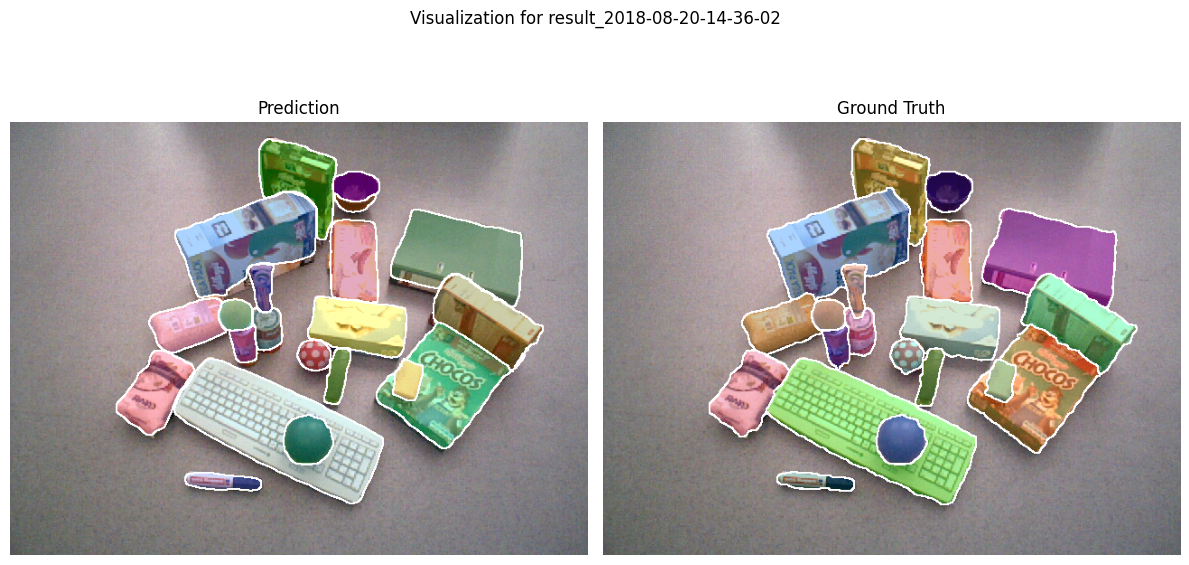

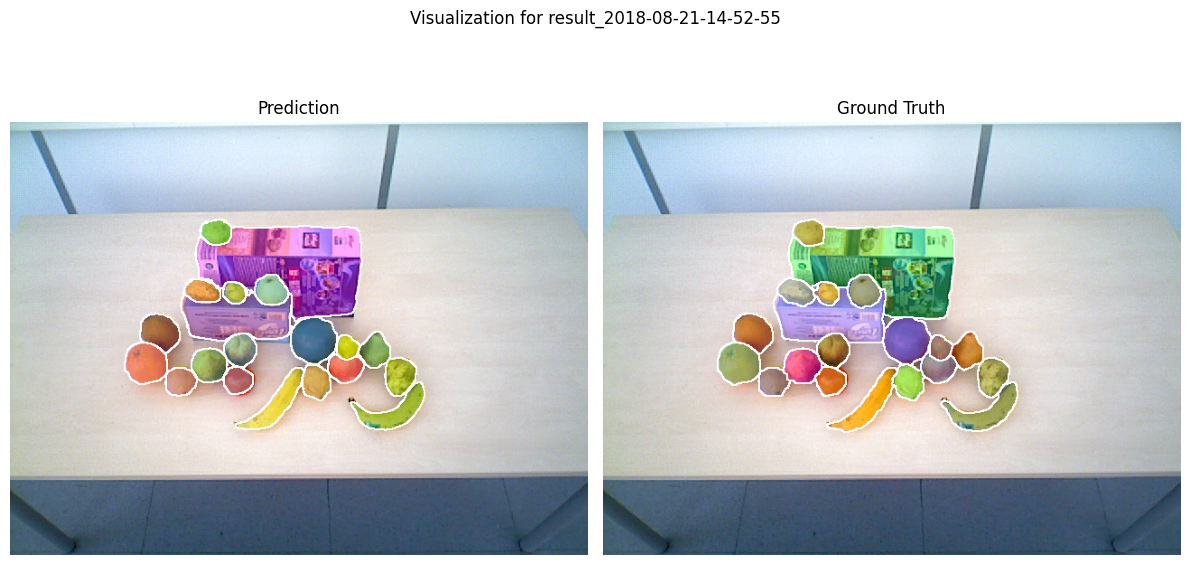

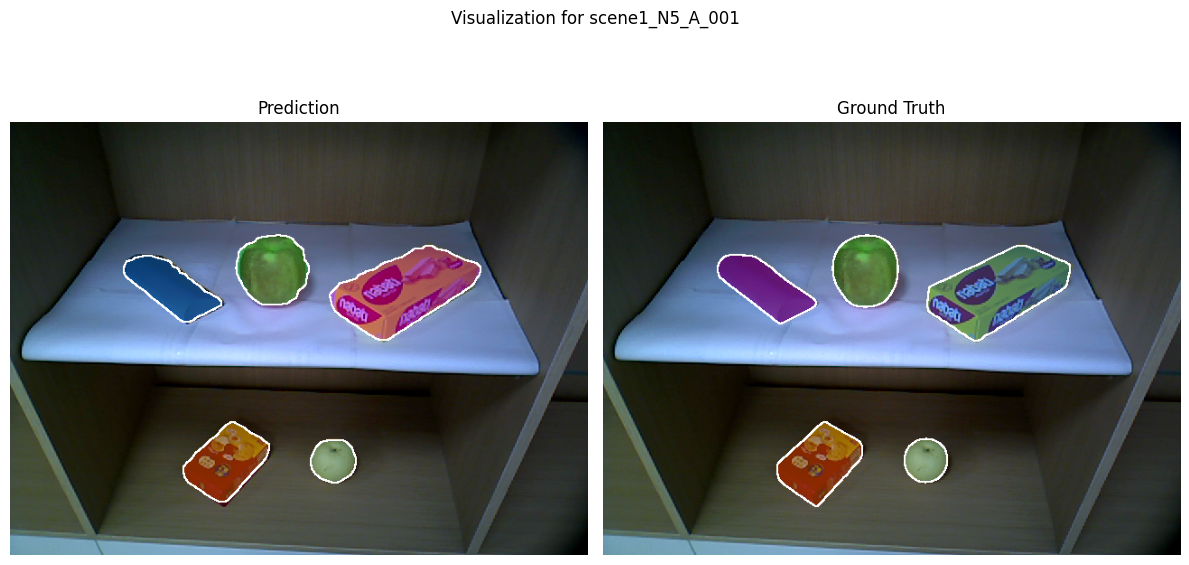

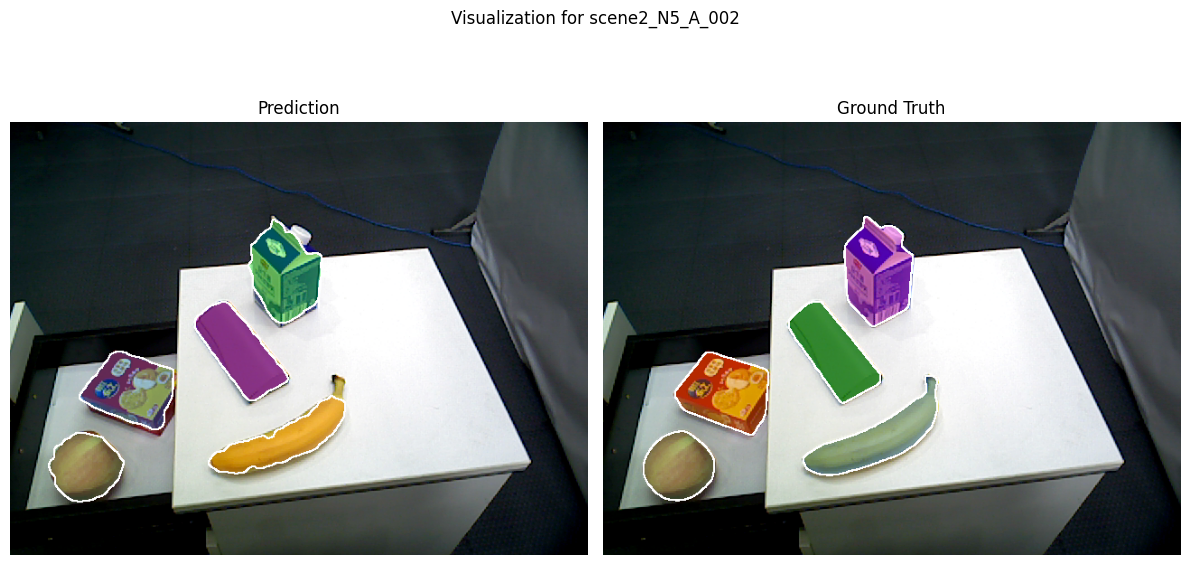

In [5]:
# Process each group of images
for group_name, paths in image_groups.items():
    gt_path = paths.get('gt')
    rgb_path = paths.get('rgb')
    depth_path = paths.get('depth')
    
    if rgb_path and depth_path:
        # Get model predictions
        proposals = model.forward_step(depth_path, rgb_path)
        
        # Visualize predictions
        pred_vis = visualize_masks(rgb_path, proposals, colors)
        
        # Read ground truth image if available
        gt_img = Image.open(gt_path) if gt_path else None
        
        # Create figure with 1 row, 2 columns
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot prediction
        axes[0].imshow(pred_vis)
        axes[0].set_title('Prediction')
        axes[0].axis('off')
        
        # Plot ground truth if available
        if gt_img:
            axes[1].imshow(gt_img)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
        
        # Set overall title
        plt.suptitle(f'Visualization for {group_name}', y=1.02)
        
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
        plt.close()